In [1]:
import sys
sys.path.append("..")

import os
import argparse
import multiprocessing
import pdb
import random
from datetime import datetime

from PIL import Image
from coco_captions_dataset import CocoCaptionsDataset
from utils import load_checkpoint, convert_sentences_to_word_idxs

import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
sns.set(
    style="darkgrid"
)

from tqdm import tqdm

import torch
import torchvision.transforms as T
import torch.backends.cudnn as cudnn

IMAGENET_MEAN   = [0.485, 0.456, 0.406]
IMAGENET_STD    = [0.229, 0.224, 0.225]
FEAT_EMBED_SIZE = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

In [2]:
model_checkpoint_filename = '../models/vdan_pretrained_model.pth'

image_path = '000000401862.jpg'
image_long_path = '../resources/COCO_2017/val2017/' + image_path
batch_size = 64

In [3]:
captions_val_fname = '../resources/COCO_2017/annotations/captions_val2017.json'
val_data_path = '../resources/COCO_2017/val2017/'
num_workers = int(multiprocessing.cpu_count()) # Using 80% of CPU cores
print('Using %d CPU cores...' % num_workers)

Using 12 CPU cores...


In [4]:
print('[{}] Loading saved model weights: {}...'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), model_checkpoint_filename))
_, model, optimizer_state_dict, word_map, model_params, train_params = load_checkpoint(model_checkpoint_filename)
model.to(device)
model.eval()
print('[{}] Done!\n'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

[2021-02-11 17:36:56] Loading saved model weights: ../models/cvpr2020_straight_retrained_model.pth...
[2021-02-11 17:37:46] Done!



In [5]:
print('[{}] Computing image features for {} ...'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), image_long_path))
img_transform = T.Compose([T.Resize((224,224)),
                           T.ToTensor(),
                           T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)])

img_original = Image.open(image_long_path).convert('RGB')
img = img_transform(img_original).unsqueeze(0).to(device)

# Extracting image features
with torch.no_grad():
    imgs_feats, resnet_output = model.get_img_embedding(img)
resnet_output = torch.cat(batch_size*[resnet_output])

print('[{}] Done!\n'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

[2021-02-11 17:37:46] Computing image features for ../resources/COCO_2017/val2017/000000401862.jpg ...
[2021-02-11 17:37:47] Done!



In [6]:
test_data = CocoCaptionsDataset(root = val_data_path,
                                annFile = captions_val_fname,
                                word_map = word_map,
                                num_sentences=10,
                                img_transform=img_transform,
                                annotations_transform=T.ToTensor(),
                                dataset_proportion=1.,
                                generate_negatives=False)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            num_workers=num_workers,
                                            shuffle=True)

print('[{}] Extracting COCO annotations features...'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

num_imgs = len(test_data)
docs_feats = np.ndarray((num_imgs,FEAT_EMBED_SIZE), dtype=np.float32)
docs_attention = np.ndarray((num_imgs,test_data.num_sentences), dtype=np.float32)
docs_text = []
conditioning_image_id = None

for i, (img_path, captions, _, documents, sentences_per_document, words_per_sentence, is_negative_sample) in enumerate(tqdm(test_dataloader)):
    docs_text += [list(x) for x in np.array(captions).T]
    if image_path in img_path:
        conditioning_image_id = i*batch_size + list(img_path).index(image_path)
        print("Found image! {} ID:{} Docs:\n{}".format(image_path, conditioning_image_id, docs_text[conditioning_image_id]))
        
    documents = documents.squeeze(1).to(device)  # (batch_size, sentence_limit, word_limit)
    sentences_per_document = sentences_per_document.to(device) # (batch_size)
    words_per_sentence = words_per_sentence.to(device)  # (batch_size, sentence_limit)
    
    # Extracting COCO annotations features
    with torch.no_grad():
        annotation_feats, _, sentence_alphas = model.get_text_embedding(documents, sentences_per_document, words_per_sentence, resnet_output)
    docs_feats[i*batch_size:min((i+1)*batch_size,num_imgs),:] = annotation_feats.detach().cpu().numpy()
    docs_attention[i*batch_size:min((i+1)*batch_size,num_imgs),:] = sentence_alphas.detach().cpu().numpy()
    
dots = np.matmul(docs_feats, imgs_feats.detach().cpu().numpy().transpose()).squeeze()

  0%|          | 0/79 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[2021-02-11 17:37:47] Extracting COCO annotations features...


  6%|▋         | 5/79 [00:02<00:40,  1.84it/s]

Found image! 000000401862.jpg ID:299 Docs:
['Several boats in the water docked at a marina.', 'PEOPLE WAITING IN LINE TO GET FOOD FROM A FOOD TRUCK', 'Empty boats docked on the water in a harbor.', 'a line of food trucks and a group of people stand by', 'People line up to buy food from a food truck.', 'Several rows of boats docked on a body of water.', 'people standing in line beside a food truck', 'People are lined up by a red food truck.', 'Many boats anchored on docks in the harbor.', 'Boats floating in rows at the dock in the river']


100%|██████████| 79/79 [00:11<00:00,  7.12it/s]


In [7]:
tsne = TSNE(perplexity=30, n_iter=5000)
docs_embedded_original = tsne.fit_transform(docs_feats)

In [8]:
zoom_offset = np.array([-5, -7])
zoom_center = np.average(docs_embedded_original, axis=0, weights=dots.clip(0, 1))
zoom_radius = 20

x1 = zoom_center[0]/np.linalg.norm(zoom_center)
x2 = 1
y1 = zoom_center[1]/np.linalg.norm(zoom_center)
y2 = 0
rot = np.array(
    [[  x1*x2 + y1*y2 , x1*y2 - x2*y1],
     [-(x1*y2 - x2*y1), x1*x2 + y1*y2]])
print(zoom_center)

rot = np.array([[1.0,0.0], [0.0,1.0]])

zoom_center = (rot @ zoom_center.T) + zoom_offset
print(zoom_center)

[ 19.822088 -92.86023 ]
[ 14.82208824 -99.86022949]


In [9]:
docs_embedded = (rot @docs_embedded_original.T).T

['0.01 | Several boats in the water docked at a marina.', '0.16 | PEOPLE WAITING IN LINE TO GET FOOD FROM A FOOD TRUCK', '0.01 | Empty boats docked on the water in a harbor.', '0.16 | a line of food trucks and a group of people stand by', '0.17 | People line up to buy food from a food truck.', '0.02 | Several rows of boats docked on a body of water.', '0.24 | people standing in line beside a food truck', '0.20 | People are lined up by a red food truck.', '0.01 | Many boats anchored on docks in the harbor.', '0.01 | Boats floating in rows at the dock in the river']


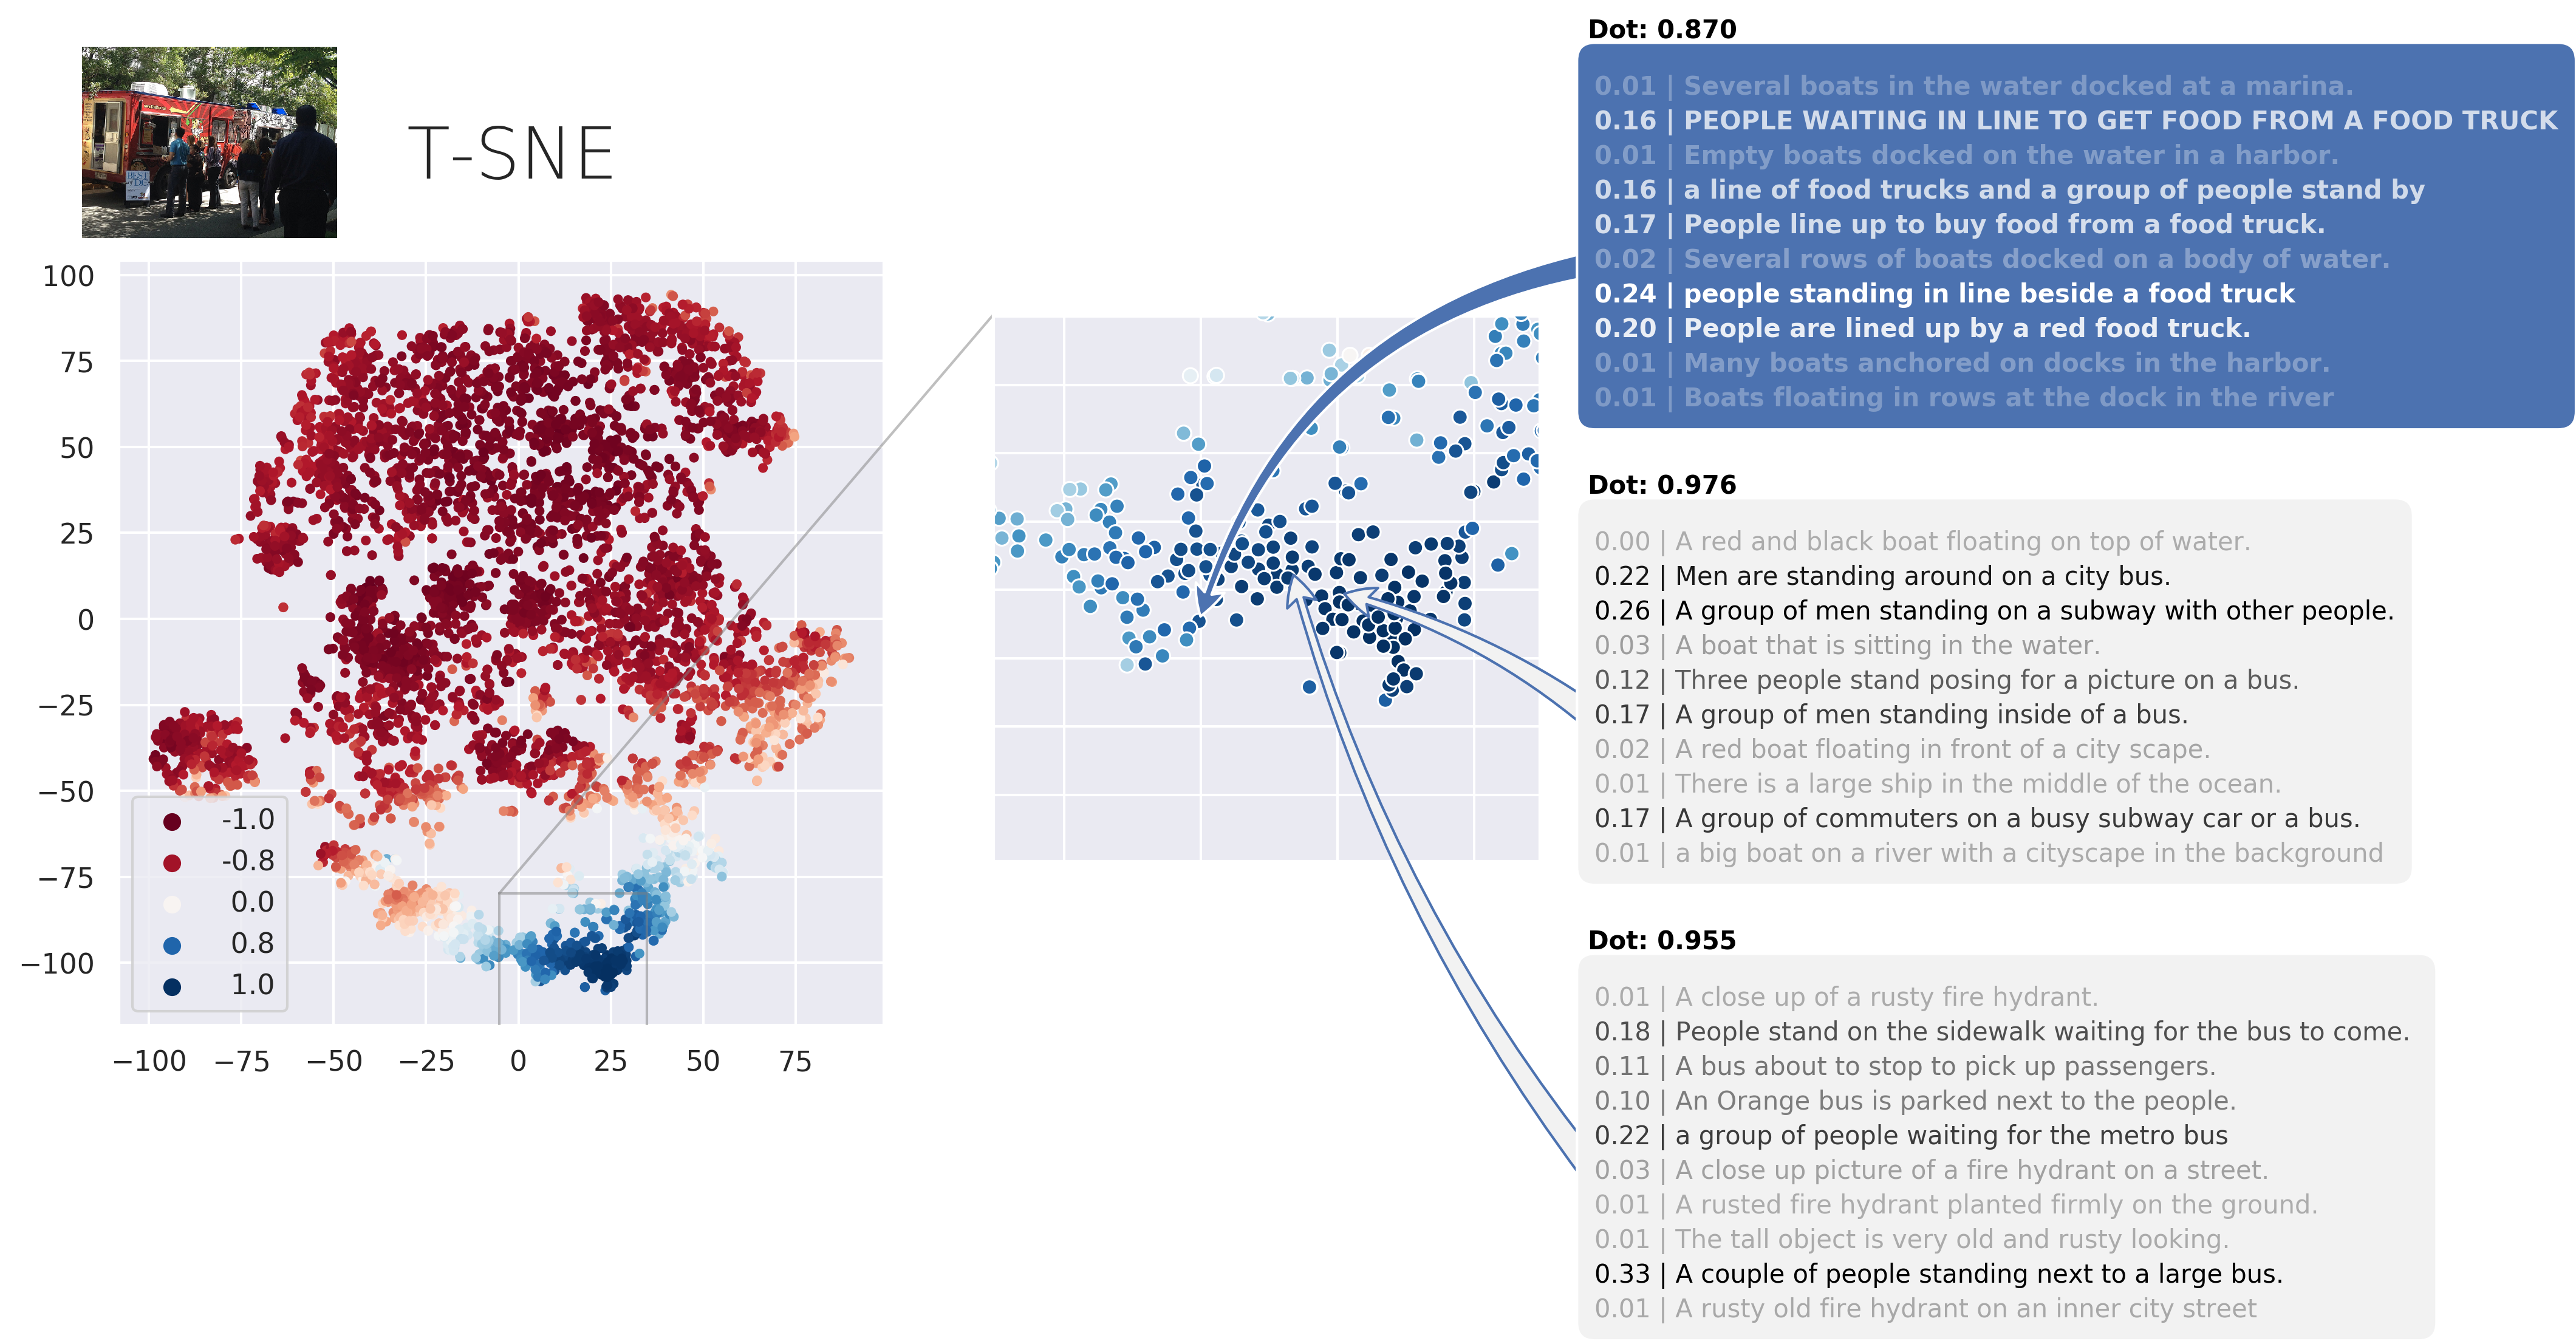

In [12]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["figure.dpi"] = 300

plot_ax = plt.axes([0.05,0.1, 0.35, 0.7], frameon=True)
scatter = sns.scatterplot(docs_embedded[:,0], docs_embedded[:,1], hue=dots, s=15, linewidth=0, palette="RdBu", legend="brief", ax=plot_ax)

for t in scatter.get_legend().texts:
    if float(t.get_text()) > 1:
        t.set_text(' 1.0')
    if float(t.get_text()) < -1:
        t.set_text('-1.0')
    if t.get_text()[0] not in [' ', '-']:
        t.set_text(' '+t.get_text())

text_ax = plt.axes([0.45,0.25, 0.25, 0.5], frameon=True)
data_to_axis = (text_ax.transAxes + text_ax.transData).inverted()
scatter_zoom = sns.scatterplot(docs_embedded[:,0], docs_embedded[:,1], hue=dots, palette="RdBu", legend=False, ax=text_ax)

x1, x2 = zoom_center[0]-zoom_radius, zoom_center[0]+zoom_radius
y1, y2 = zoom_center[1]-zoom_radius, zoom_center[1]+zoom_radius

selected_points = []
for i in range(docs_embedded.shape[0]):
    if i == conditioning_image_id:
        continue
    x = docs_embedded[i,0]
    y = docs_embedded[i,1]
    if x > x1 and x < x2 and y > y1 and y < y2 and dots[i] > 0.9:
        selected_points += [{'x':x, 'y':y ,'dot': dots[i]
                             ,'atts':  docs_attention[i]
                            #,'text': '\n'.join(docs_text[i])
                             ,'texts': ["{:.2f} | {}".format(docs_attention[i][j], docs_text[i][j]) for j in range(test_data.num_sentences)]
                            }]
n_texts = 3
selected_points = random.choices(selected_points, k=n_texts-1)
selected_points.sort(reverse=True, key=lambda x: x['dot']*60 + (x['x']-zoom_center[0]) + x['y']-zoom_center[1])
selected_points = [{"x": docs_embedded[conditioning_image_id,0]
                   ,"y": docs_embedded[conditioning_image_id,1]
                   ,"dot": dots[conditioning_image_id]
                   ,'atts': docs_attention[conditioning_image_id]
                  #,"text": "\n".join(map(lambda x: x.rstrip(), docs_text[conditioning_image_id]))
                   ,'texts':  ["{:.2f} | {}".format(docs_attention[conditioning_image_id][j], docs_text[conditioning_image_id][j]) for j in range(test_data.num_sentences)]
                   }] + selected_points
                  

text_y_offset = (zoom_radius*5)/n_texts
text_x = zoom_center[0] + zoom_radius*1.2
text_y = zoom_center[1] + zoom_radius - text_y_offset/5
text_line_offset_y = (text_y_offset/test_data.num_sentences) * 0.76#* 0.795
text_box_offset_y0 = 4
text_box_offset_y1 = 2
arrowstyle = ArrowStyle('fancy', head_width=1.0, head_length=1.0, tail_width=0.8)

for i in reversed(range(n_texts)):
    center_offset = float(n_texts-i)/n_texts * text_box_offset_y0 + float(i)/n_texts * text_box_offset_y1
    scatter_zoom.annotate(""
                         ,(selected_points[i]['x'],selected_points[i]['y'])
                         ,(text_x, text_y-i*text_y_offset + text_y_offset*0.3125)
                         ,arrowprops = {'arrowstyle': arrowstyle
                                       ,'color': '0.95' if i != 0 else 'b'
                                       ,'ec': 'b' if i != 0 else 'white'
                                       ,'connectionstyle': "arc3,rad={}".format(float(n_texts-i)/n_texts * 0.3 + float(i)/n_texts * -0.3)})
    
    scatter_zoom.text(text_x - 0.5
                     ,text_y-i*text_y_offset+ text_y_offset*0.8075
                     ,"Dot: {:0.3f}".format(selected_points[i]['dot'])
                     ,horizontalalignment='left', size='small', color='black', weight='semibold')
    
    bgbox = scatter_zoom.annotate("\n".join(selected_points[i]['texts'])
                         ,(selected_points[i]['x'],selected_points[i]['y'])
                         ,(text_x, text_y - i*text_y_offset)
                         , horizontalalignment='left', size='small'
                         , bbox=dict(boxstyle='round', pad=0.7, fc='0.95' if i != 0 else 'b')
                         , weight='normal' if i != 0 else 'semibold'
                         , linespacing=1.5
                         , alpha=0)

    a_min = selected_points[i]['atts'].min()
    a_max = selected_points[i]['atts'].max()
    for j in range(test_data.num_sentences):
        scatter_zoom.annotate(selected_points[i]['texts'][j]
                             ,(selected_points[i]['x'], selected_points[i]['y'])
                             ,(text_x, text_y - i*text_y_offset + (test_data.num_sentences-j-1)*text_line_offset_y)
                             , horizontalalignment='left', size='small'
                             , weight='normal' if i != 0 else 'semibold'
                             , color='black' if i != 0 else 'white'
                             , alpha=((selected_points[i]['atts'][j]-a_min)/(a_max-a_min) + 0.4)/ 1.4)
text_ax.set_xlim(x1, x2)
text_ax.set_ylim(y1, y2)
text_ax.set_xticklabels('')
text_ax.set_yticklabels('')

plot_ax.indicate_inset_zoom(text_ax)

img_ax = plt.axes([0.004, 0.82, 0.175, 0.175], frameon=True)
img_ax.imshow(img_original)
img_ax.axis('off')

plt.suptitle('T-SNE', x=0.23, y=0.925, size=28, weight='light')

img_name = os.path.splitext(os.path.basename(image_path))[0]
plt.savefig('tsne_att_' + img_name + '.png', dpi=400, bbox_inches='tight')
plt.show()

In [11]:
print('[{}] Done!\n'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

[2021-02-11 17:40:47] Done!

